# ECBD_PD_proyecto

## Preprocesado de datos

### Descripción de los datos

El proyecto de datos utiliza un conjunto de datos extraído de Kaggle en esta [referencia](https://www.kaggle.com/datasets/shivam2503/diamonds). Este conjunto de datos contiene información sobre diferentes características de diamantes, como puedan ser sus quilates (_carats_), su color (_color_) o su precio en _US dollars_ (_price_).

Con este conjunto de datos se busca realizar un modelo de aprendizaje automático que sea capaz de estimar el precio de un diamante acorde a sus características.

Las características en cuestión son las siguientes:

| Campo | Descripción |
|--------|--------|
| `price` | Precio en _US dollars_ ($326 - $18.823) |
|`carat` ([quilate](https://es.wikipedia.org/wiki/Quilate))| Peso del diamante (0,2 - 5,01)|
|`cut`|Calidad del corte del diamante. En orden ascendente: _Fair_, _Good_, _Very Good_, _Premium_, _Ideal_|
|`color`|Color del diamante, de J (peor) a D (mejor)|
|`clarity`| Medida de claridad del diamante. En orden ascendente: _I1_, _SI2_, _SI1_, _VS2_, _VS1_, _VVS2_, _VVS1_, _IF_|
|`x`| Largo en _mm_ (0 - 10,74)|
|`y`| Ancho en _mm_ (0 - 58,9)|
|`z`| Profundidad en _mm_ (0 - 31,8)|
|`depth`| Porcentaje de profundida del diamante respecto a su tamaño ($depth =  2 \cdot \frac{z}{x + y}$) (43 - 79)|
|`table`| Anchura del extremo del diamante respecto al punto más distante (43 - 95)|

En este caso, la característica objetivo que se busca estimar es el precio del diamante (`price`), por lo que debemos construir los modelos de aprendizaje con esta característica en mente.

In [123]:
import pandas as pd

df = pd.read_csv("../data/diamonds.csv").drop(columns = "Unnamed: 0")
display(df)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### Análisis previo de los datos

#### Analítica de datos faltantes

Comenzamos por analizar los campos del dataset en busca de registros con valores faltantes o nulo. 

In [124]:
pd.DataFrame(
    data = df.isna().sum(),
    columns = ["Valores faltantes"]
)

,Valores faltantes
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


Aparentemente no existen valores faltantes o nulos en nuestro conjunto de datos.

#### Analítica de atributos redundantes

Para analizar una posible redundancia entre atributos, calcularemos la correlación entre ellos utilizando diferentes métodos. Estos métodos son:

* Correlación de Pearson
* Correlación de Spearman

Comenzaremos por graficar las posibles combinaciones de variables:

Exception ignored in: <function tqdm.__del__ at 0x00000188EA9B6480>
Traceback (most recent call last):
  File "c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


[]

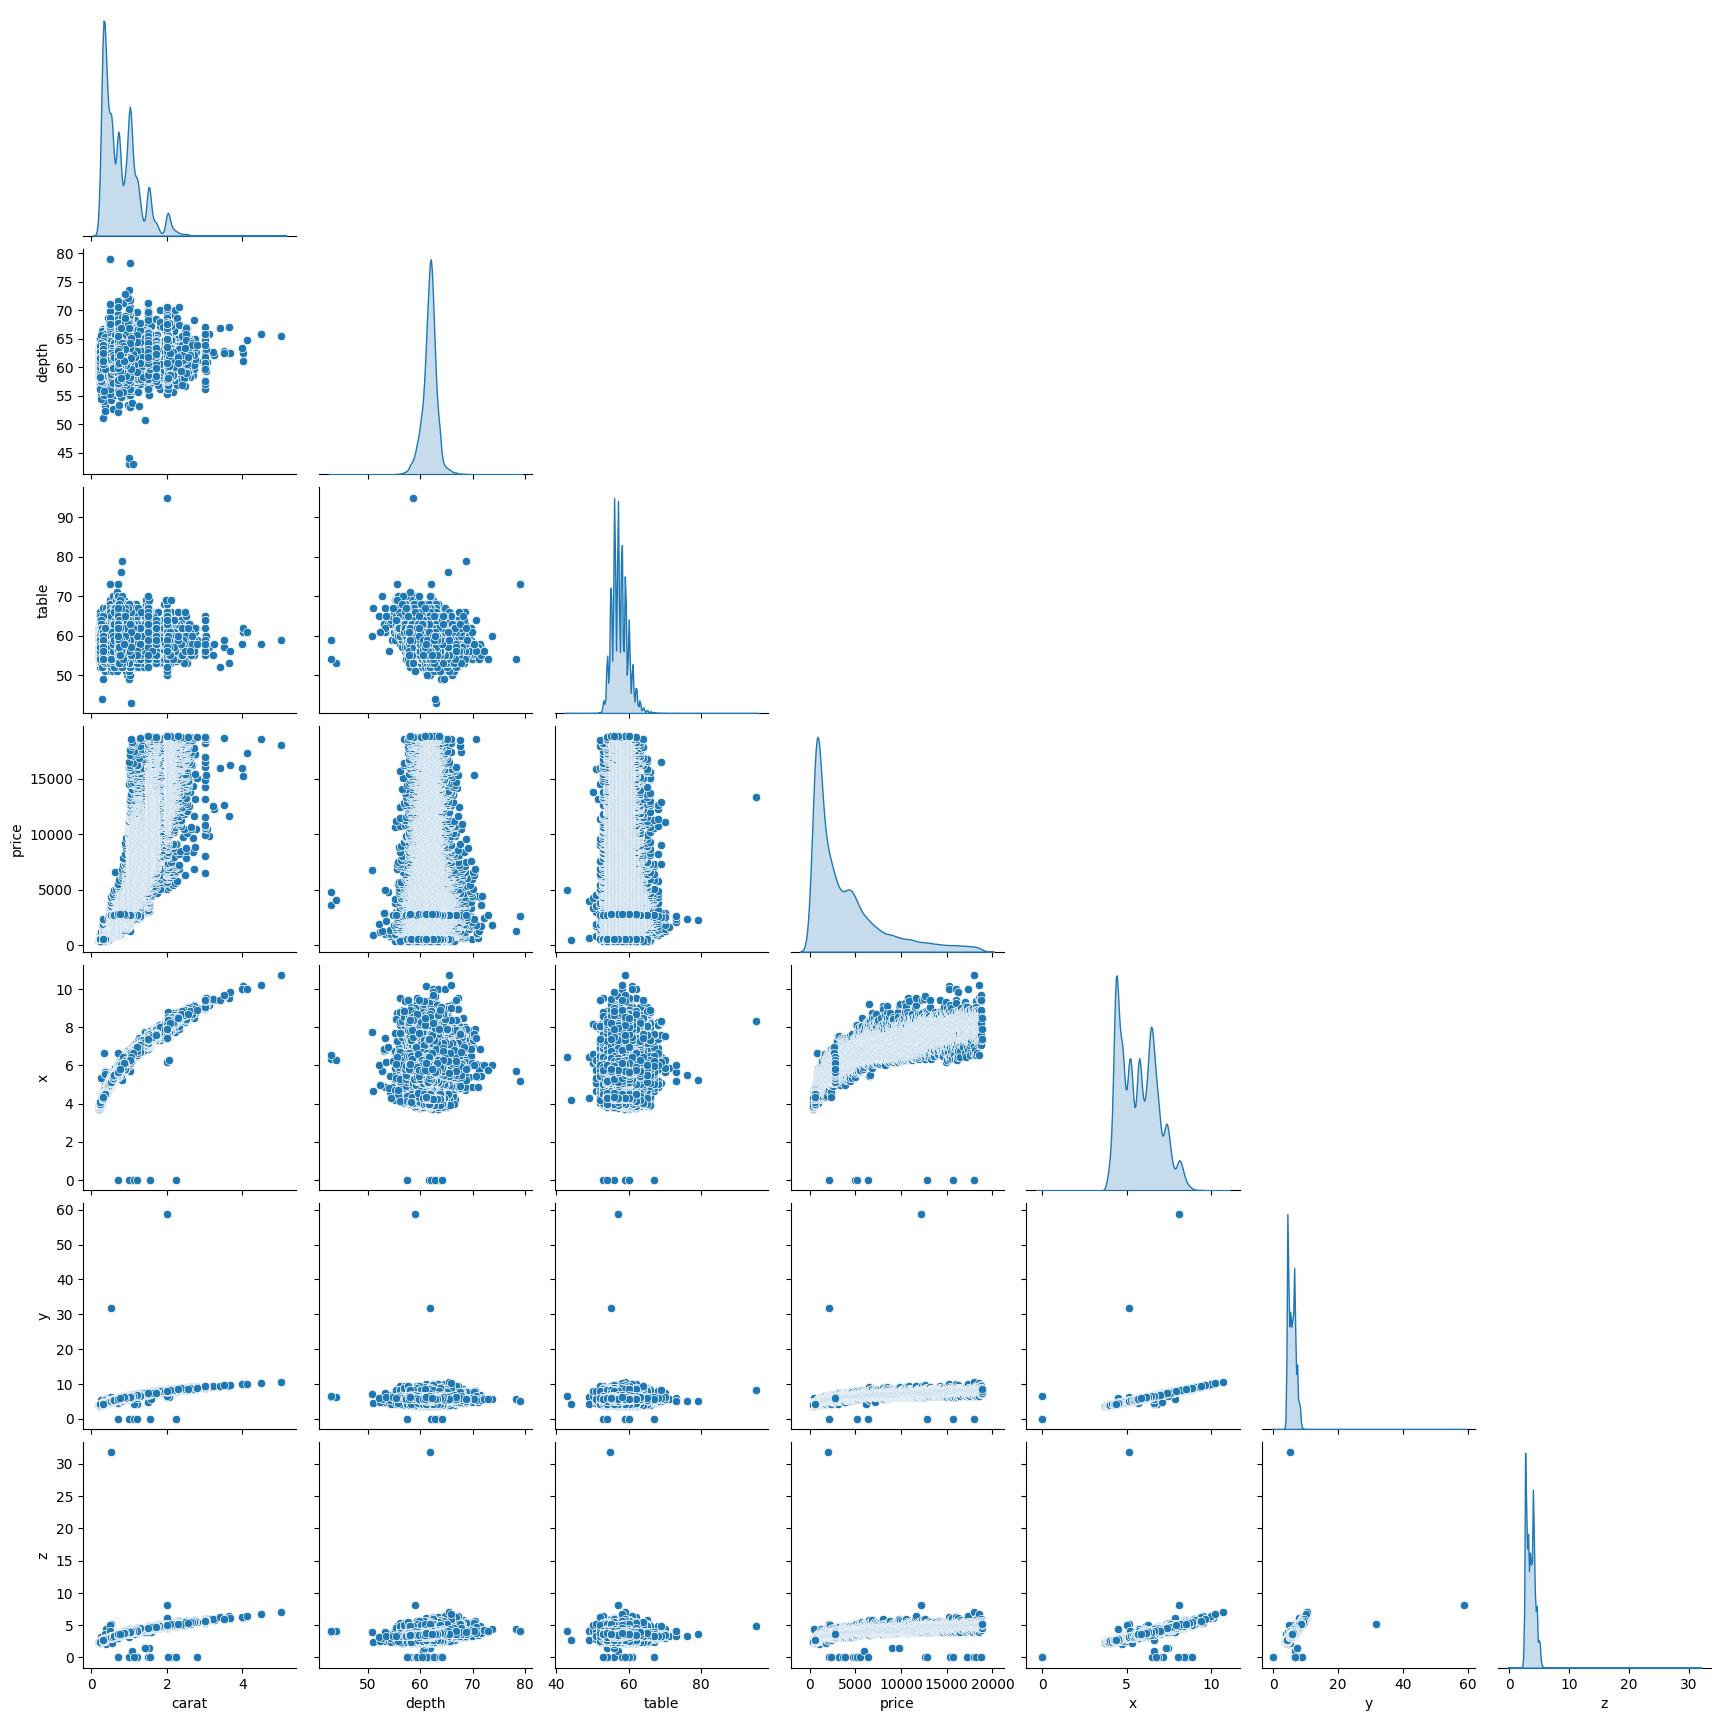

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

sns.pairplot(
    data = df[numeric_columns],
    corner = True,
    diag_kind = "kde"
)
plt.plot()

Podemos observar cómo existen a simple vista variables altamente relacionadas, como puedan ser los pares [`z`, `carat`], [`y`, `x`] y [`z`, `price`]. También podemos observar variables con poca relación aparente lineal entre sí, como puedan ser los pares [`z`, `depth`] o [`x`, `table`].

Ejecutando sobre estas variables los coeficientes de _Pearson_ y _Spearman_, obtenemos los siguientes valores:

<Axes: title={'center': 'Correlación de Spearman'}>

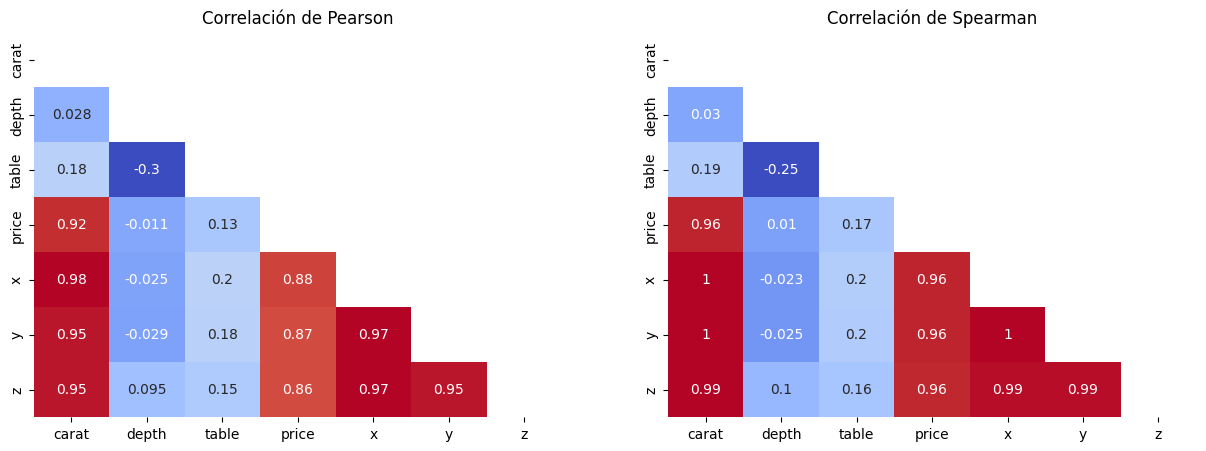

In [126]:
import numpy as np

p_man = df.corr(method = "pearson", numeric_only = True)
mask = np.triu(np.ones_like(p_man, dtype=bool))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Correlación de Pearson")
ax2.set_title("Correlación de Spearman")

sns.heatmap(
    data = df.corr(method = "pearson", numeric_only=True),
    annot = True,
    cmap = "coolwarm",
    mask = mask,
    ax = ax1,
    cbar = False
)

sns.heatmap(
    data = df.corr(method = "spearman", numeric_only=True),
    annot = True,
    cmap = "coolwarm",
    mask = mask,
    ax = ax2,
    cbar = False
)

Podemos observar que, si bien existe una alta correlación entre `carat` y los atributos de medida del diamante (`x`, `y`, y `z`), o entre `price` y las mismas unidades de medida, el resto de variables parecen ser completamente independientes, con la excepción del par [`table`, `depth`] que parecen demostrar correlaciones negativas moderadas en ambos casos.

Para poder analizar las variables categóricas, debemos aplicar correlación entre variables por hipótesis de _chi-square_.

Comenzamos con la hipótesis de que las variables a analizar son independientes entre sí, para posteriormente calcular el _p-value_ de la hipótesis (valor de confianza) aplicando _chi-square_:

* Si el _p-value_ es menor a 0.05 la hipótesis se negará: Las variables son dependientes.
* Si el _p-value_ es suficientemente alto (mayor a 0.05) la hipótesis no puede ser negada: Las variables son independientes.

In [127]:
from scipy.stats import chi2_contingency
from itertools import combinations

P_VALUE_THRESHOLD = 0.05

p_values_df = pd.DataFrame(columns = ["col1", "col2", "p_value", "variable_dependency"])

categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns = list(combinations(categorical_columns, 2))

for col1, col2 in categorical_columns:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df[col1], df[col2]))
    if p < P_VALUE_THRESHOLD:
        p_values_df = pd.concat([
            p_values_df,
            pd.DataFrame(
                data = [[col1, col2, p, "dependientes"]],
                columns = ["col1", "col2", "p_value", "variable_dependency"]
            )
        ])

display(p_values_df)

C:\Users\cabre\AppData\Local\Temp\ipykernel_7788\1757848462.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  p_values_df = pd.concat([


,col1,col2,p_value,variable_dependency
0,cut,color,1.394512e-51,dependientes
0,cut,clarity,0.000000e+00,dependientes
0,color,clarity,0.000000e+00,dependientes


Podemos determinar que las 3 variables categóricas son dependientes entre sí en pares.

Este estudio de correlaciones entre variables podrá ser aplicado posteriormente para reducir el número de variables del conjunto de datos mediante algoritmos de reducción de dimensionalidad.

#### Analítica de duplicidad de registros

Para comprobar la posible duplicidad de registros, y sabiendo que todos los atributos están correctamente formateados (lo que nos evita tener que utilizar técnicas de distancia entre textos), podemos utilizar directamente los métodos integrados de _Pandas_ para detectar duplicados.

In [128]:
df[df.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


Podemos observar un total de 146 registros duplicados de nuestro conjunto de datos, un 0.027% de los registros originales.

#### Analítica de valores anómalos (_outliers_)

Para analizar la existencia de valores outliers en nuestro conjunto de datos, realizaremos un análisis de cuartiles para cada variable numérica. De esta forma buscamos localizar aquellos valores que no se encuentren dentro de los límites esperados.

El criterio para determinar un posible valor outlier está en marcar como "posibles outliers" todos aquellos valores que se alejen en 1,5 veces del rango intercuartílico.

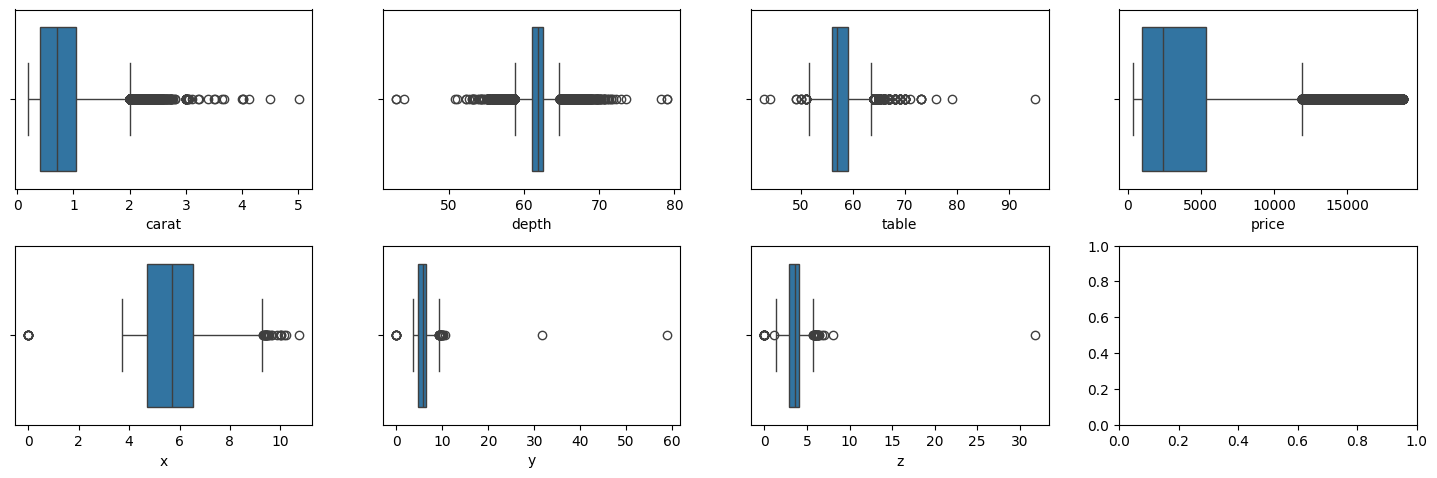

In [129]:
fig, ax = plt.subplots(
    figsize = (15, 5),
    ncols = 4,
    nrows = len(numeric_columns) // 4 + 1,
)
fig.tight_layout(pad = 2.0)


for i, col in enumerate(numeric_columns):
    sub_ax = ax[i // 4][i % 4]

    sns.boxplot(
        data = df,
        x = col,
        ax = sub_ax
    )

En todas las variables numéricas podemos observar datos alejados del rango intercuartílico, que podrían ser marcados como _outliers_. Sin embargo, no todos los valores extremos de estas gráficas anteriores deberían ser contados como valores anómalos, pues muchos de ellos serán simplemente muestras poco comunes pero válidas.

Cada atributo debe ser analizado de forma individual.

##### `carat`

<Axes: xlabel='carat'>

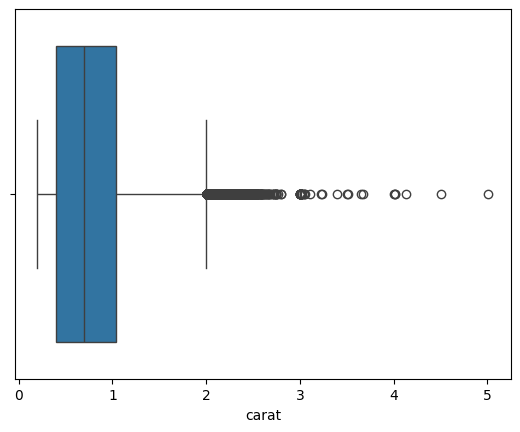

In [130]:
sns.boxplot(data = df, x = 'carat')

Podemos observar que la mayor parte de los diamantes registrados son de 1 o 2 quilate, siendo el grueso de "posibles _outliers_" diamantes de _2.x_ quilates. Son valores perfectamente válidos, pues aunque poco frecuentes es plausible la existencia de diamantes de 3-5 quilates.

##### `depth`

<Axes: xlabel='depth'>

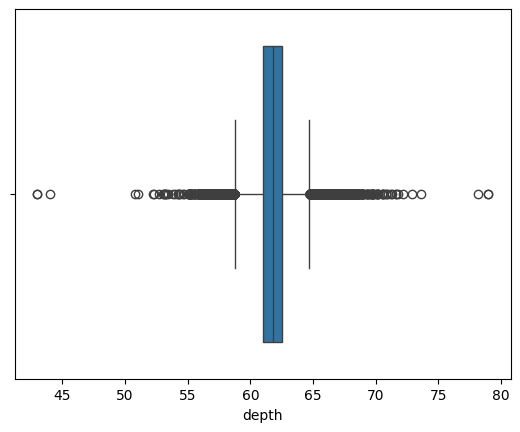

In [131]:
sns.boxplot(data = df, x = 'depth')

En el campo `depth` no se aprecian valores anómalos, pues no deja de ser una variable derivada de otras anteriores.

##### `table`

<Axes: xlabel='table'>

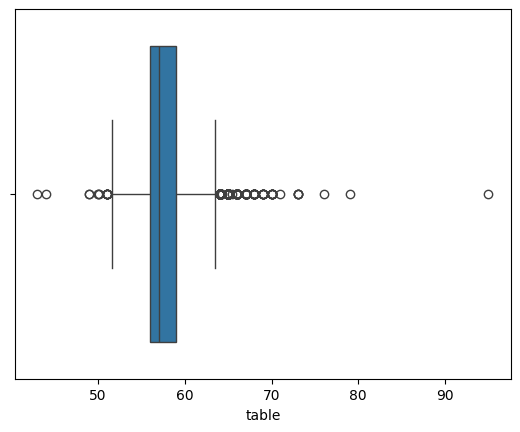

In [132]:
sns.boxplot(data = df, x = 'table')

El campo `table` no despierta tampoco sospechas de valores anómalos, salvo por la muestra extrema de `table = 95`. Se podría eliminar ese punto para evitar posibles problemas.

##### `price`

<Axes: xlabel='price'>

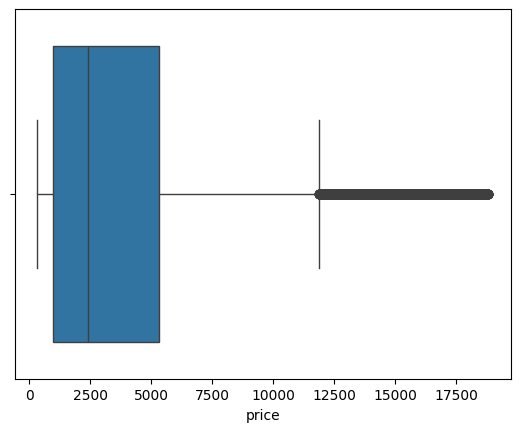

In [133]:
sns.boxplot(data = df, x = 'price')

El atributo `price` y su distribución de puntos extremos negros ubicados al final del gráfico de cajas nos indica una distribución de datos asimétrica, donde hay muchas entradas con precios bajos y pocas con precios elevados.

##### `x`

<Axes: xlabel='x'>

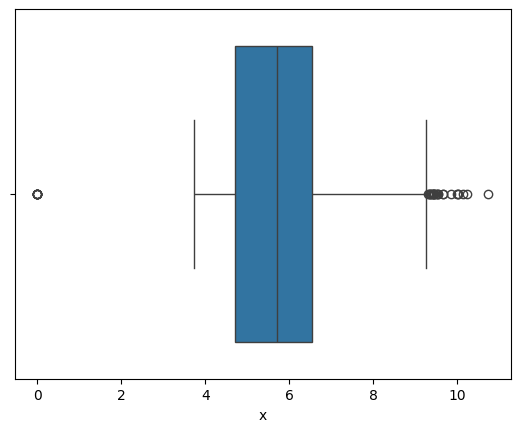

In [134]:
sns.boxplot(data = df, x = 'x')

En el caso de `x` podemos observar valores outliers a partir de la longitud ~9, lo que puede indicar pocos diamantes tan grandes. Sin embargo, también se observan al menos una entrada de longitud `x = 0`, lo cual es virtualmente imposible.

Se recomienda para este atributo eliminar esas entradas.

##### `y`

<Axes: xlabel='y'>

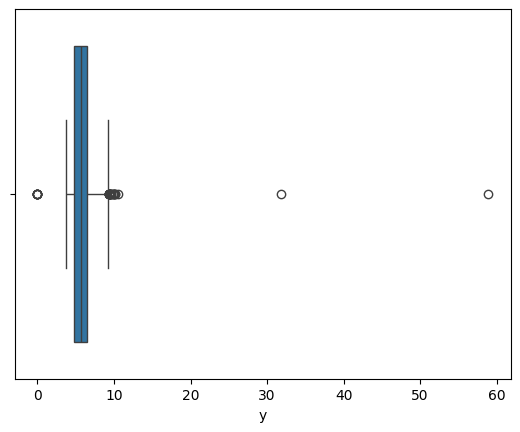

In [135]:
sns.boxplot(data = df, x = 'y')

De forma similar al atributo `x`, en el caso del atributo `y` podemos observar ciertos valores elevados marcados como outliers y unos pocos valores de altura nula.

Para este atributo se recomienda eliminar aquellas entradas con `y = 0`.

##### `z`

<Axes: xlabel='z'>

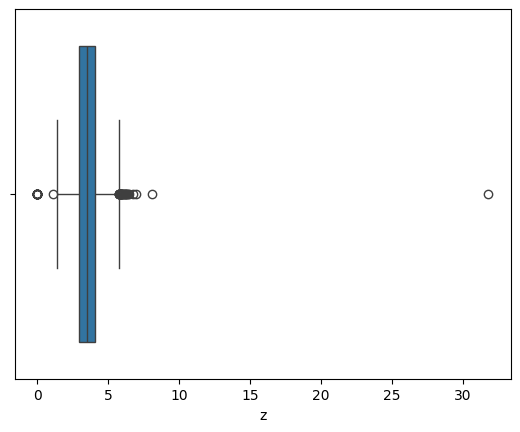

In [136]:
sns.boxplot(data = df, x = 'z')

De forma similar al atributo `x`, en el caso del atributo `z` podemos observar ciertos valores elevados marcados como outliers y unos pocos valores de profundidad nula.

Para este atributo se recomienda eliminar aquellas entradas con `z = 0`.

### Corrección de atributos redundantes

Buscamos reducir el número de atributos de nuestro conjunto de datos. Para ello, utilizaremos el método integrado (_embedded_).

Text(0.5, 1.0, 'Importancia de los atributos')

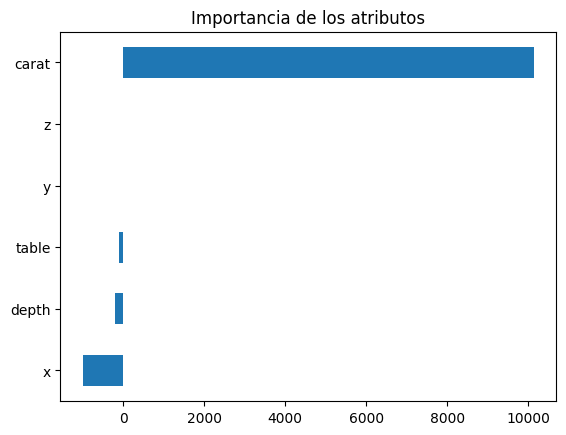

In [137]:
from sklearn.linear_model import LassoCV

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns.drop("price")

reg = LassoCV()
reg.fit(df[numeric_columns], df["price"])
coef = pd.Series(reg.coef_, index = numeric_columns)

imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Importancia de los atributos")

Podemos observar que, después del proceso iterativo que sigue el algoritmo Lasso CV para asignar importancia a las variables, los atributos `z` e `y` son marcados como "irrelevantes" para nuestro proyecto (coeficiente = 0), por lo que pueden ser eliminados sin afectar drásticamente el rendimiento de posibles modelos.

In [138]:
df = df.drop(columns = ["y", "z"])

### Corrección de duplicidad de registros

Para la eliminación de registros duplicados se ha decidido utilizar los métodos integrados de `pandas` para eliminar registros duplicados de un _Dataframe_.

In [139]:
df = df.drop_duplicates()

display(df.duplicated().sum())

0

### Corrección de _outliers_

Para la corrección de _outliers_, se decidió anteriormente eliminar aquellas entradas con los campos de distancia (`x`, `y` y `z`). Sabiendo que los campos `y` y `z` han sido eliminados del conjunto de datos por ser irrelevantes, solo queda eliminar aquellas entradas cuyo $x = 0$.

In [140]:
df = df.drop(df[df["x"] == 0].index)

display(df[df["x"] == 0].size)

0

In [141]:
df.head()

,carat,cut,color,clarity,depth,table,price,x
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89
2,0.23,Good,E,VS1,56.9,65.0,327,4.05
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20
4,0.31,Good,J,SI2,63.3,58.0,335,4.34


### Normalización de datos

Para el proceso de normalización de variables numéricas, primero debemos observar la distribución de las variables numéricas de las que disponemos:

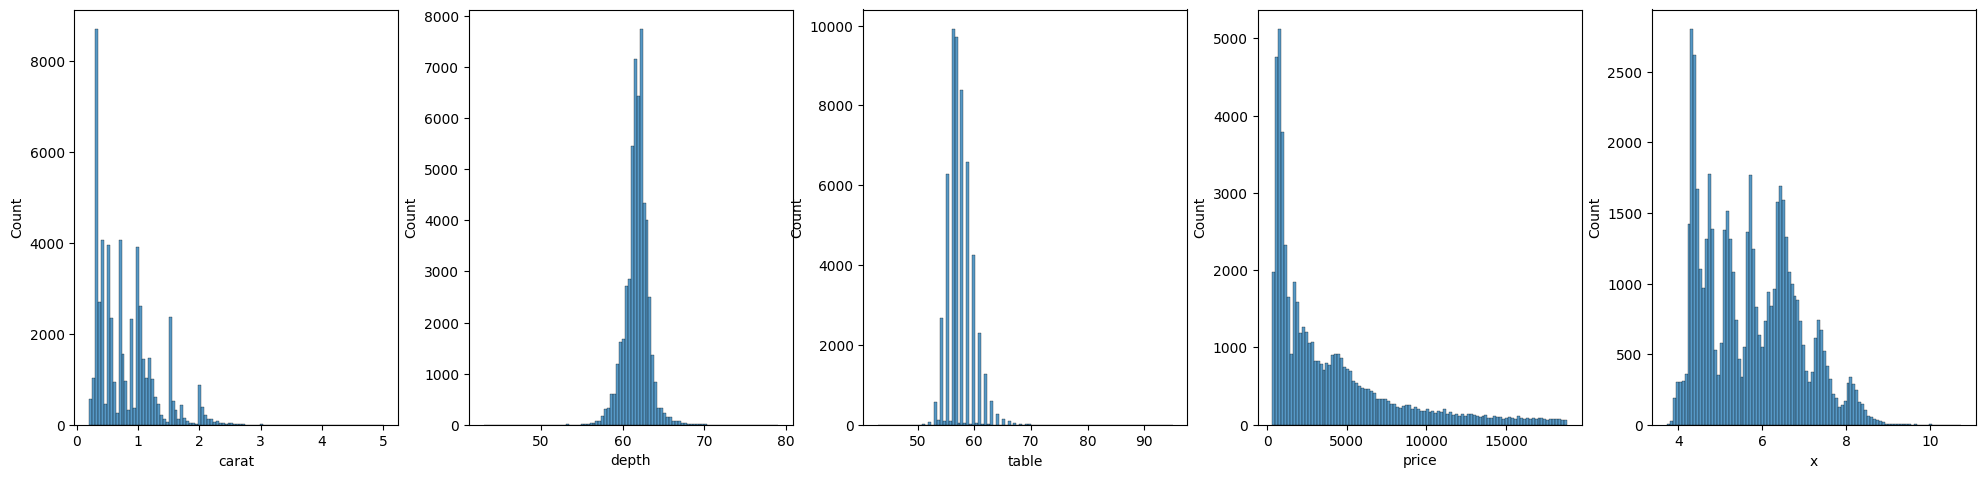

In [142]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

fig, ax = plt.subplots(figsize = (20, 5), ncols = 5)

fig.tight_layout(pad = 2.0)

for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = df,
        x = col,
        bins = 100,
        ax = ax[i]
    )

Como podemos observar, las variables `depth` y table muestran una distribución cercana a la normal, en comparación con las variables `carat`, `price` y `x`. Para este conjunto de 5 variables vamos a aplicar las siguientes normalizaciones:

* Normalización por _z-score_
    * `depth`
    * `table`
* Normalización por _min\_max_
    * `carat`
    * `price`
    * `x`

In [143]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

old_df = df.copy(deep = True)

# Normalizacion por z_score
df['depth'] = std_scaler.fit_transform(df[['depth']])
df['table'] = std_scaler.fit_transform(df[['table']])

# Normalizacion por minmax
df['carat'] = minmax_scaler.fit_transform(df[['carat']])
df['x']     = minmax_scaler.fit_transform(df[['x']])
df['price'] = minmax_scaler.fit_transform(df[['price']])

Una vez calculados, podremos mostrar los datos originales frente a sus versiones normalizadas:

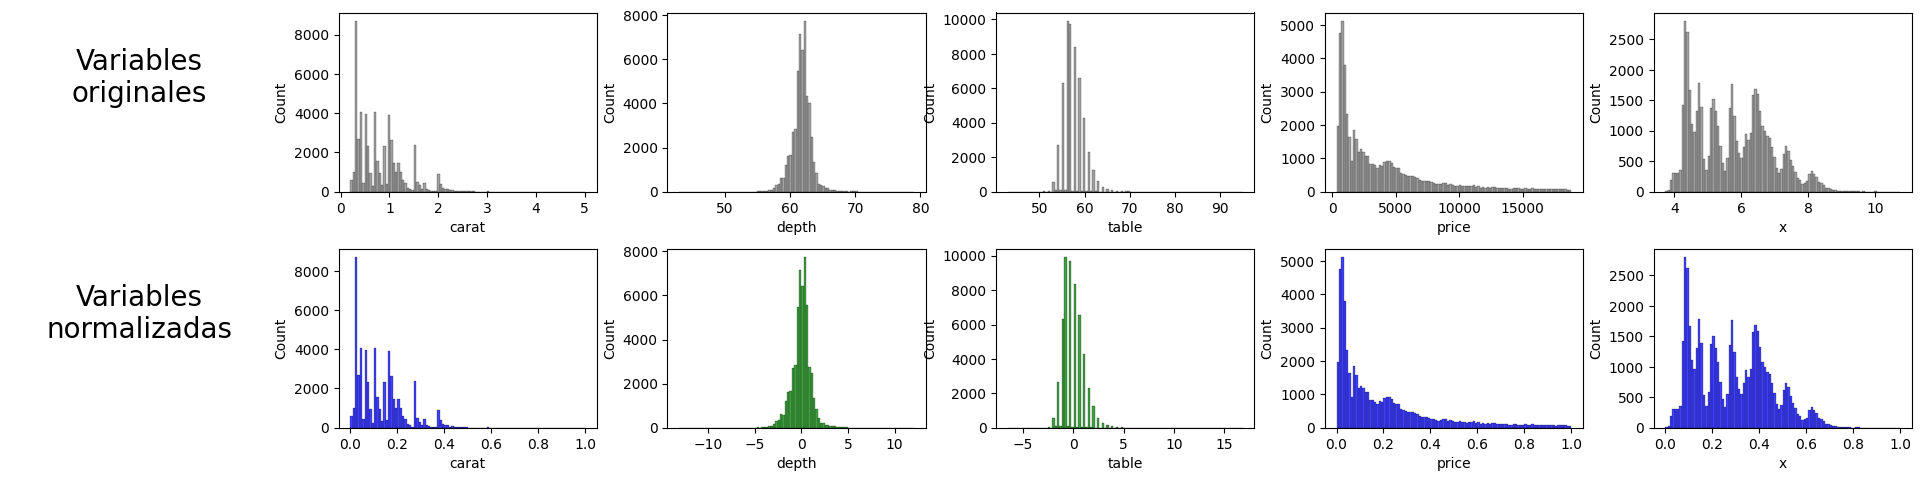

In [144]:
fig, ax = plt.subplots(figsize = (20, 5), ncols = 6, nrows = 2)
fig.tight_layout(pad = 2.0)

# Variables numericas originales
ax[0][0].axis('off')
ax[0][0].text(0.5, 0.5, 'Variables\noriginales', fontsize = 20, ha = 'center')
for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = old_df,
        x = col,
        bins = 100,
        ax = ax[0][i + 1],
        color = "gray"
    )

# Variables numericas normalizadas
ax[1][0].axis('off')
ax[1][0].text(0.5, 0.5, 'Variables\nnormalizadas', fontsize = 20, ha = 'center')
for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = df,
        x = col,
        bins = 100,
        ax = ax[1][i + 1],
        color = "green" if col in ['depth', 'table'] else "blue"
    )


En azul se marcan las variables normalizadas con el algoritmo _min\_max_, mientras que en verde las variables normalizadas con _z-score_.

### Codificación de variables

Para que los futuros modelos de regresión funcionen correctamente, codificaremos las variables categóricas para convertirlas en variables _dummies_.

In [145]:
df = pd.get_dummies(df, drop_first = True)
display(df)

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.006237,-0.173118,-1.101200,0.000000,0.031384,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.002079,-1.361453,1.584881,0.000000,0.022825,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.006237,-3.388612,3.375601,0.000054,0.045649,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,0.018711,0.456001,0.241840,0.000433,0.067047,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False
4,0.022869,1.085119,0.241840,0.000487,0.087019,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.108108,-0.662432,-0.205840,0.131427,0.288160,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.108108,0.945315,-1.101200,0.131427,0.279601,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.103950,0.735609,1.137201,0.131427,0.275321,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.137214,-0.522628,0.241840,0.131427,0.345221,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False


### Discretización de variables

En caso de que alguno de los modelos de extracción de conocimiento diseñados en los apartados posteriores, generaremos un conjunto de datos idéntico al que ya tenemos, pero con el atributo `price` discretizado en intervalos de _$2.500_.

In [146]:
max_price = old_df["price"].max()

imbalanced_df = df.copy(deep = True)

intervalos = range(0, old_df["price"].max() + 2501, 2500)
etiquetas = [f"{i} - {i + 2500}" for i in intervalos[:-1]]
imbalanced_df["price"] = pd.cut(old_df["price"], bins = intervalos, labels = etiquetas)

display(imbalanced_df)

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.006237,-0.173118,-1.101200,0 - 2500,0.031384,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.002079,-1.361453,1.584881,0 - 2500,0.022825,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.006237,-3.388612,3.375601,0 - 2500,0.045649,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,0.018711,0.456001,0.241840,0 - 2500,0.067047,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False
4,0.022869,1.085119,0.241840,0 - 2500,0.087019,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.108108,-0.662432,-0.205840,2500 - 5000,0.288160,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.108108,0.945315,-1.101200,2500 - 5000,0.279601,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.103950,0.735609,1.137201,2500 - 5000,0.275321,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.137214,-0.522628,0.241840,2500 - 5000,0.345221,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False


Habiendo generado la discretización de atributos, mediremos la frecuencia de cada clase para detectar posibles clases minoritarias.

<Axes: xlabel='price'>

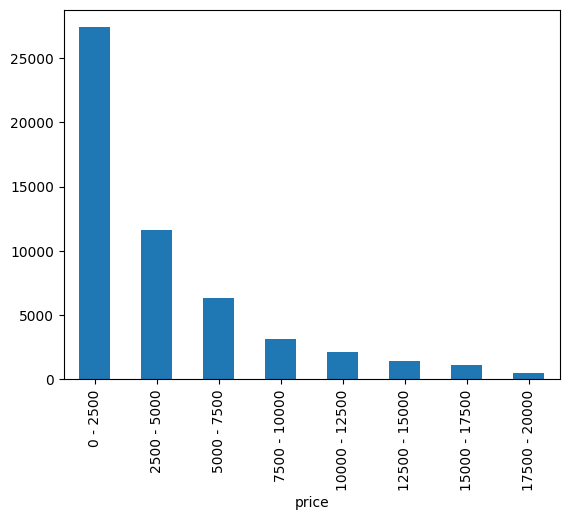

In [147]:
imbalanced_df['price'].value_counts().plot(kind = 'bar')

Podemos detectar un claro desbalance de clases, donde la mayor parte de los registros se encuentran dentro de la categoría $[0, 2500)$. Este problema deberá ser solventado aplicando técnicas de _oversampling_ a la hora de implementar modelos de clasificación.

## Extracción de conocimiento

### Modelo de predicción (regresión)

#### Descripción del modelo

En esta primera mitad del apartado de "Extracción de conocimiento" se busca generar y entrenar un modelo de aprendizaje automático de regresión que permita, para unos datos de entrada sobre diamantes, estimar su precio.

#### Creación y entrenamiento del modelo

Para la creación del modelo, vamos a utilizar dos algoritmos de regresión diferentes, con el objetivo de comparar sus rendimientos y escoger un modelo vencedor. Estos algoritmos serán:

* Algoritmo de **regresión lineal**
* Algoritmo de **árbol de decision de regresión**

In [148]:
# Creacion de modelos de regresion lineal
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()

#### Testeo del modelo

En el testeo del modelo de regresión usaremos la **Desviación Media Residual** o _**RMD (Residual Mean Deviance)**_ como métrica de rendimiento de ambos modelos. Esta métrica define la variación media entre los valores predichos por nuestro modelo de aprendizaje frente a los valores reales, y se calcula de la siguiente forma:

$$
RMD = \frac{\sum_{i=1}^n (y_i - \hat{y}_i) ^ 2}{n - k}
$$

Donde:
* $y_i$ = Valor **observado** de la variable $y$
* $\hat{y}_i$ = Valor **real** de la variable $y$
* $n$ = Número de observaciones
* $k$ = Número de nodos terminales del árbol

Cuanto más baja sea la RMD, mejor será el rendimiento general del modelo, pues indica que el modelo obtiene unos resultados más cercanos.

In [149]:
# Testeo de modelos
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

def calc_rmd(y_true, y_pred):
    residuos = y_true - y_pred
    deviance = np.mean(np.square(residuos))
    return deviance

scorer = make_scorer(calc_rmd)

#### Creación de subconjuntos de entrenamiento y prueba

Para nuestro modelo de predicción, utilizaremos un sistema de validación cruzada con el objetivo de asegurarnos de que el modelo generado no presente sobreajuste, además de comprobar su rendimiento en diferentes instancias del problema.

La validación cruzada a ejecutar contará con 5 pliegues (_folds_).

#### Ejecución del modelo

In [150]:
# Entrenamiento de modelos y calculo de metricas
OBJECTIVE_ATTRIBUTE = "price"

cv_results = cross_validate(
    estimator = decision_tree,
    X = df.drop(columns = [OBJECTIVE_ATTRIBUTE]),
    y = df[OBJECTIVE_ATTRIBUTE],
    scoring = scorer,
    return_estimator = True
)
decision_tree_results = cv_results['test_score']
decision_tree = cv_results['estimator'][np.argmax(decision_tree_results)]

cv_results = cross_validate(
    estimator = linear_regression,
    X = df.drop(columns = [OBJECTIVE_ATTRIBUTE]),
    y = df[OBJECTIVE_ATTRIBUTE],
    scoring = scorer,
    return_estimator = True
)
linear_regression_results = cv_results['test_score']
linear_regression = cv_results['estimator'][np.argmax(linear_regression_results)]

#### Análisis de resultados

Para medir el rendimiento del modelo tras la validación cruzada, debemos observar primero su RMD en cada iteración para cada algoritmo utilizado.

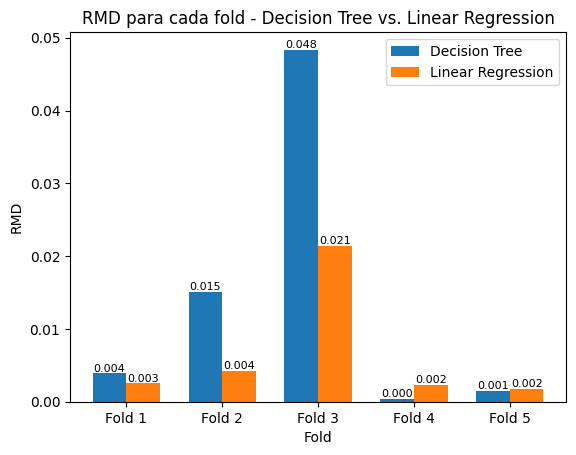

In [151]:
# Número de folds
num_folds = len(decision_tree_results)

# Índices para cada fold
indices = np.arange(num_folds)

# Ancho de las barras
bar_width = 0.35

# Crear el gráfico de barras
fig, ax = plt.subplots()
bar1 = ax.bar(indices, decision_tree_results, bar_width, label='Decision Tree')
bar2 = ax.bar(indices + bar_width, linear_regression_results, bar_width, label='Linear Regression')

# Configurar el gráfico
ax.set_xlabel('Fold')
ax.set_ylabel('RMD')
ax.set_title('RMD para cada fold - Decision Tree vs. Linear Regression')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels([f'Fold {i+1}' for i in range(num_folds)])
ax.legend()

for i, rect in enumerate(bar1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize = 8)

for i, rect in enumerate(bar2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize = 8)

# Mostrar el gráfico
plt.show()

Como se puede observar, el RMD se mantiene bajo en la mayoría de _folds_, con la excepción del _fold_ 3, donde el RMD del Decision Tree asciende a 0.048. Aparentemente el modelo de regresión lineal implementado obtiene mejores resultados, pues en la mayoría de casos obtiene resultados de RMD iguales o inferiores a los del árbol de decisión.

Realizando la media ponderada de los RMD de cada algoritmo en los diferentes _folds_, obtenemos la siguiente gráfica.

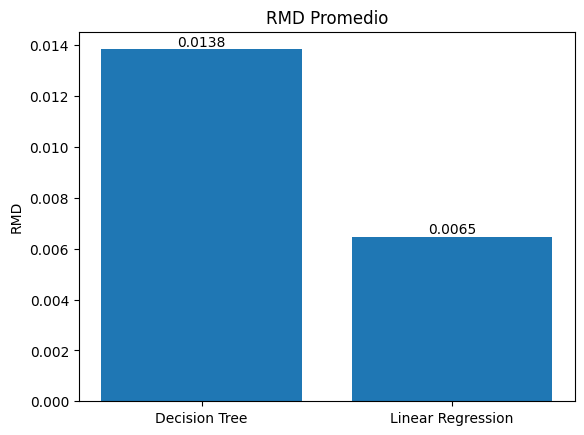

In [152]:
decision_tree_mean_rmd = np.mean(decision_tree_results)
linear_regression_mean_rmd = np.mean(linear_regression_results)

fig, ax = plt.subplots()
bars = ax.bar(
    x=["Decision Tree", "Linear Regression"],
    height=[decision_tree_mean_rmd, linear_regression_mean_rmd]
)

# Añadir etiquetas con los valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Configurar el gráfico
ax.set_ylabel('RMD')
ax.set_title('RMD Promedio')
plt.show()

Podemos confirmar que, respecto al RDM, el modelo de regresión lineal parece funcionar mejor que el modelo de decisión.

Además de mostrar el RMD, podemos graficar la diferencia entre predicciones para cada entrada de nuestro conjunto de datos, para observar la diferencia de funcionamiento entre ambos algoritmos.

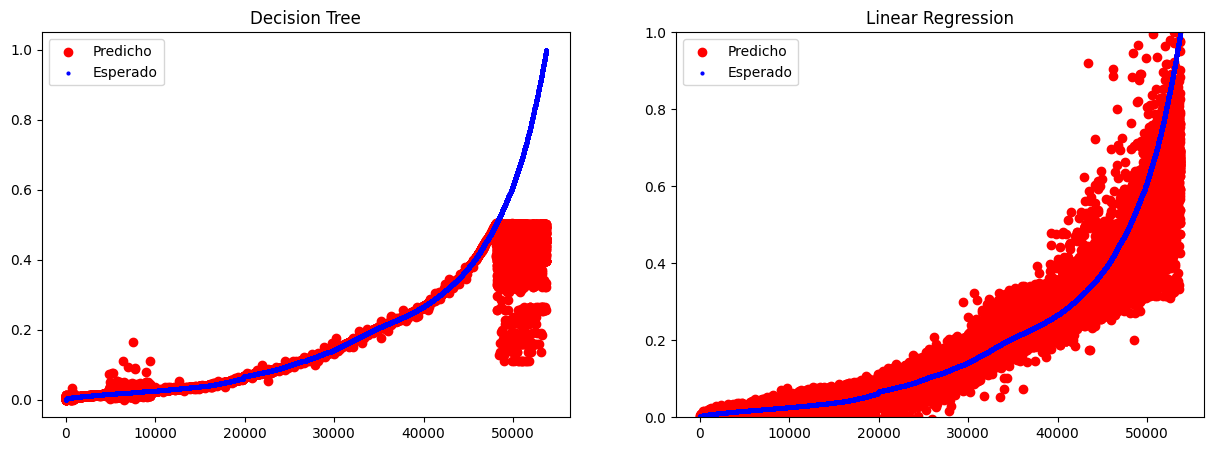

In [153]:
sorted_values = df.sort_values(by = "price", ascending = True)

expected = sorted_values["price"]
dt_predicted = decision_tree.predict(sorted_values.drop(columns = "price"))
lr_predicted = linear_regression.predict(sorted_values.drop(columns = "price"))

indices = np.arange(len(expected))

fig, ax = plt.subplots(ncols = 2, figsize=(15, 5))

ax[0].scatter(indices, dt_predicted, label = "Predicho", color = "red")
ax[0].scatter(indices, expected, label = "Esperado", color = "blue", s = 4)
ax[0].set_title("Decision Tree")
ax[0].legend()

ax[1].scatter(indices, lr_predicted, label = "Predicho", color = "red")
ax[1].scatter(indices, expected, label = "Esperado", color = "blue", s = 4)
ax[1].set_title("Linear Regression")
ax[1].legend()
ax[1].set_ylim([0, 1])

plt.show()

In [154]:
old_df["price"].max()

18823

Podemos observar que el model de árbol de decisión es capaz de estimar finamente los precios de aquellos diamantes hasta (aproximadamente) 0.5 del precio máximo del _dataset_, unos 9.411,5 dólares. A partir de esa cifra, tenderá a estimar todos los diamantes como si tuvieran un precio de 9.400 dólares.

En el caso de la regresión lineal, podemos observar como realiza predicciones más acertadas que el modelo anterior a partir de los 9.400 dólares. Sin embargo, las predicciones del rango $[0, 9.400)$ son mucho menos exactas.

### Modelo de clasificación

#### Descripción del modelo

Alternativamente al modelo de regresión, donde la variable `price` se expresaba como un valor numérico y había sido estimada directamente, en el modelo de clasificación se utilizará un conjunto de datos con la variable `price` discretizada, convertida en intervalos para poder ser interpretados como clases.

Estos intervalos dividen el precio de los diamantes en lotes de $2.500, de la siguiente forma:

* $[0, 2500)$
* $[2500, 5000)$
* $[5000, 7500)$
* etc

#### Creación y entrenamiento del modelo

Para la creación del modelo se utilizarán los siguientes algoritmos de clasificación de datos:

* Algoritmo de **árbol de decisión**
* Algoritmo **Random Forest**
* Algoritmo **KNN** 

In [155]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

dtree_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()
knn_classifier = KNeighborsClassifier()

#### Testeo del modelo

Las métricas de rendimiento a ser utilizadas en este modelo son las siguientes:

* Exactitud (_Accuracy_)
* Precisión (_Precision_)
* Sensibilidad (_Recall_)
* Matriz de confusión (_Cofusion Matrix_)

In [156]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#### Creación de subconjuntos de entrenamiento y prueba

En este caso vamos a aplicar un entrenamiento básico sin validación cruzada, donde únicamente generaremos una división entrenamiento-prueba por conjunto de datos y algoritmo.

Adicionalmente, aplicaremos técnicas de _oversampling_ al conjunto de datos para resolver el problema de desbalance observado en el apartado "Discretización de variables".

<Axes: xlabel='price'>

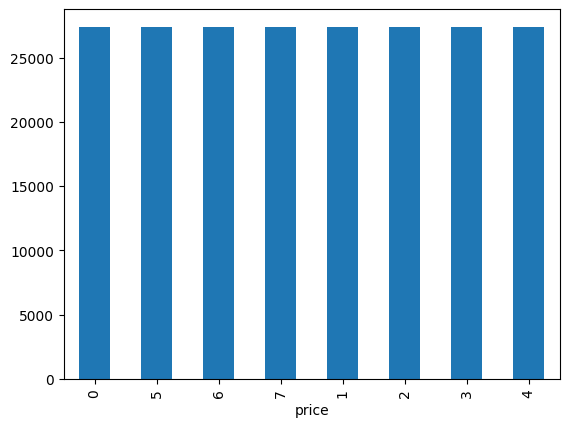

In [157]:
# Codificacion de variable 'objetivo'
from sklearn.preprocessing import LabelEncoder

imbalanced_df['price'] = LabelEncoder().fit_transform(imbalanced_df['price'])

# Oversampling
from imblearn.over_sampling import SMOTE

balanced_df = SMOTE().fit_resample(imbalanced_df, imbalanced_df["price"])[0]
balanced_df['price'].value_counts().plot(kind = 'bar')

#### Ejecución del modelo

In [166]:
from sklearn.model_selection import cross_val_predict, train_test_split

classifiers = [dtree_classifier, rf_classifier, knn_classifier]
datasets = [imbalanced_df, balanced_df]
datasets_names = ["imbalanced", "balanced"]

results = pd.DataFrame(columns = ["classifier", "dataset", "accuracy", "precision", "recall"])
confusion_matrixes = []

for classifier in classifiers:
    for i, dataset in enumerate(datasets):
        X = dataset.drop(columns = ["price"])
        y = dataset["price"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

        y_pred = cross_val_predict(classifier, X_train, y_train, cv = 10)

        accuracy = accuracy_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred, average = "macro")
        recall = recall_score(y_train, y_pred, average = "macro")

        results = pd.concat([
            results,
            pd.DataFrame(
                data = [[classifier, datasets_names[i], accuracy, precision, recall]],
                columns = ["classifier", "dataset", "accuracy", "precision", "recall"]
            )
        ])

        confusion_matrixes.append(
            confusion_matrix(y_train, y_pred)
        )

C:\Users\cabre\AppData\Local\Temp\ipykernel_7788\3550430069.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([


In [168]:
confusion_matrix

[array([[18576,     0,     0,     0,     0,   609,     3,     0],
        [    0,   916,   212,    45,    17,     5,    36,   298],
        [    0,   207,   562,   179,    51,     2,    10,    33],
        [    0,    59,   176,   437,   131,     0,     5,     5],
        [    0,    19,    48,   146,   130,     1,     2,     1],
        [  569,     7,     2,     3,     0,  6768,   733,     6],
        [    1,    27,    10,     9,     2,   704,  3253,   394],
        [    1,   283,    35,     3,     2,     9,   394,  1459]],
       dtype=int64),
 array([[18737,     0,     0,     0,     0,   450,     1,     0],
        [    0,  1010,   184,    49,    13,     1,     7,   265],
        [    0,   213,   617,   170,    36,     0,     1,     7],
        [    0,    49,   165,   508,    89,     1,     0,     1],
        [    0,     7,    56,   154,   128,     0,     1,     1],
        [  414,     4,     0,     0,     0,  7138,   527,     5],
        [    0,    21,     9,     3,     1,   548,  35

In [167]:
display(results)

,classifier,dataset,accuracy,precision,recall
0,DecisionTreeClassifier(),imbalanced,0.853864,0.658362,0.657650
0,RandomForestClassifier(),imbalanced,0.884054,0.709581,0.703302
0,KNeighborsClassifier(),imbalanced,0.625722,0.376039,0.295896


In [ ]:

# TODO: Mostrar las matrices de confusion como la grafica del normalizado de atributos

#### Análisis de resultados

### Modelo de agrupamiento

#### Descripción del modelo

#### Creación y alimentación del modelo

#### Testeo del modelo

#### Análisis de resultados